# Forecasting moss & lichen fractional cover 
# **No weights** in the loss function
## with a Neural Network using Keras
## (Reading X and Y train/test files stored locally)
### Using only 2m temperature and total precipitation from ERA5-land
### For lichen output only

### This notebook uses TensorFlow NGC Container Release 23.03-tf2-py3
### (https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tensorflow)
### and runs on a machine with 4x ARM CPUs (Neoverse N1) and 24GB RAM

In [1]:
#pip install tables

In [2]:
print('Starting imports')
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, BatchNormalization, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD, Adadelta
from tensorflow.keras import Sequential
print('Finished imports')

Starting imports
Finished imports


In [3]:
# Sets all random seeds for the program to make it fully deterministic
tf.keras.backend.experimental.enable_tf_random_generator()
tf.keras.utils.set_random_seed(12345)

In [4]:
# Defining various parameters

depth = 1
width = 8
epochs = 16
activation = 'relu'
final_activation = 'sigmoid'
batch_size = 128
learning_rate = 0.01
rho = 0.95
loss = 'Huber'
validation_split = 0.01
print('Depth = ', depth)
print('Width = ', width)
print('Hidden layer activation = ', activation)
print('Final activation = ', final_activation)
print('Learning rate = ', learning_rate)
print('Epochs = ', epochs)
print('Batch size = ', batch_size)
print('Loss function = ', loss)
print('Validation split = ', validation_split)
expname = 'TP1_365d_' + str(depth) + '_' + str(width) + '_' + str(epochs) + 'epochs-' + str(batch_size) + '_' + activation + '-' + final_activation + '_Adadelta-' + str(learning_rate) + '-' + str(rho) + '_' + loss + '_' + str(validation_split) + 'split'
print('Experiment name = ', expname)

Depth =  1
Width =  8
Hidden layer activation =  relu
Final activation =  sigmoid
Learning rate =  0.01
Epochs =  16
Batch size =  128
Loss function =  Huber
Validation split =  0.01
Experiment name =  TP1_365d_1_8_16epochs-128_relu-sigmoid_Adadelta-0.01-0.95_Huber_0.01split


# **All years** of input/output data - for training

In [5]:
# Read local .hdf5 file
path = '/home/jeani/data/'

print('Reading X_train')
X_train_file = os.path.join(path, 'X_mean_tp1_train.hdf')
input_train = pd.read_hdf(X_train_file)
input_train.fillna(0, inplace=True)
Ni_train = input_train['N']
input_train = input_train.drop(columns=['N'])

print('Reading X_test')
X_test_file = os.path.join(path, 'X_mean_tp1_test.hdf')
input_test = pd.read_hdf(X_test_file)
input_test.fillna(0, inplace=True)
Ni_test = input_test['N']
input_test = input_test.drop(columns=['N'])

print('Reading y_train')
y_train_file = os.path.join(path, 'y_mean_tp1_train.hdf')
output_train = pd.read_hdf(y_train_file)
output_train.fillna(0, inplace=True)
No_train = output_train['new_N']
output_train = output_train.drop(columns=['new_N'])

print('Reading y_test')
y_test_file = os.path.join(path, 'y_mean_tp1_test.hdf')
output_test = pd.read_hdf(y_test_file)
output_test.fillna(0, inplace=True)
No_test = output_test['new_N']
output_test = output_test.drop(columns=['new_N'])

Reading X_train
Reading X_test
Reading y_train
Reading y_test


In [6]:
train_loss_weights = (Ni_train + No_train) / 2.

In [7]:
test_loss_weights = (Ni_test + No_test) / 2.

In [8]:
input_train

,Lichen,t2m_0,t2m_1,t2m_2,t2m_3,t2m_4,t2m_5,t2m_6,t2m_7,t2m_8,...,tp_8750,tp_8751,tp_8752,tp_8753,tp_8754,tp_8755,tp_8756,tp_8757,tp_8758,tp_8759
37,0.212308,0.977626,0.979172,0.980195,0.981094,0.980679,0.979638,0.979272,0.980954,0.980093,...,7.531988,7.911303,8.125458,8.279312,8.432280,8.515192,8.596331,8.640226,8.685230,8.738436
3398,0.123333,0.969460,0.969516,0.969563,0.968850,0.967295,0.963955,0.961524,0.967927,0.970865,...,0.138114,0.140552,0.141883,0.145651,0.155849,0.181565,0.188660,0.196641,0.198636,0.199079
2747,0.078287,0.958717,0.958901,0.958894,0.959793,0.960436,0.960108,0.960259,0.962879,0.964013,...,0.475308,0.544697,0.610540,0.670618,0.718503,0.747767,0.767719,0.783016,0.794766,0.803855
2765,0.122321,0.975722,0.975749,0.976239,0.976572,0.977027,0.977774,0.978979,0.983781,0.985780,...,3.759232,4.259369,4.789879,5.254102,5.741381,6.185208,6.641229,7.126956,7.510484,7.827060
675,0.186842,0.993280,0.992567,0.991915,0.991578,0.991016,0.990852,0.989579,0.988875,0.987222,...,0.992293,1.706807,2.269683,2.554557,2.763170,3.015233,3.313409,3.566360,3.778963,4.003980
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
835,0.099288,0.968810,0.969334,0.969159,0.968895,0.969254,0.970228,0.971559,0.976834,0.976523,...,0.927781,0.927781,0.927781,0.927781,0.927781,0.927781,0.928002,0.928002,0.928446,0.928889
3264,0.113205,0.984804,0.985838,0.987426,0.988205,0.988538,0.988480,0.987478,0.984979,0.983080,...,1.425258,1.653823,1.786394,1.825856,1.845364,1.863543,1.889259,1.920961,1.948230,1.973059
1653,0.119231,0.958757,0.955444,0.953749,0.954940,0.956103,0.956400,0.957064,0.960731,0.960525,...,0.727371,0.921795,1.152576,1.407966,1.744938,2.252169,2.924118,3.832834,4.896513,5.866194
2607,0.094717,0.972968,0.972829,0.972340,0.971712,0.970634,0.969718,0.968187,0.966529,0.966880,...,2.228670,2.410679,2.614414,2.799084,2.964909,3.154456,3.234487,3.269736,3.327376,3.429133


In [9]:
output_test

,new_Lichen
989,0.079881
686,0.092609
472,0.043143
3231,0.082727
3351,0.212667
...,...
3268,0.053333
1559,0.030000
547,0.000000
3251,0.106951


In [10]:
def fullyconnected_sequential(
    input_shape: int,  # How many predictors?
    width: int,  # How wide should the layers be?
    depth: int,  # How many layers?
    activation: str,  # What nonlinearity to use?
    final_activation: str,  # Output layer?
    learning_rate: float,  # What learning rate?
    loss: str,  # What loss function?
):
    # Create a model object
    model = Sequential()

    # Then just stack layers on top of one another
    # the first specifies the shape of the inputs expected input
    model.add(Input(input_shape, name = 'Inputs'))

    # Then we stack on depth number of consectutive dense layers
    # To write more compact code we can include the activation
    # function we want to apply after each Dense block in the
    # call itself.
    for i in range(depth):
        model.add(Dense(width, activation = activation))

    # Finally we add an output layer, we want to predict
    # 1 variable, and we will probably use a linear output
    # layer, so we don't constrain the output
    model.add(Dense(1, activation = final_activation))

    # Next we need to specify the optimiser we want to use and what learning rate to use
    opt = Adadelta(learning_rate=learning_rate, rho=rho, epsilon=1e-07)

    # Finally we compile the model, specifying the loss we want to minimise
    # Here we pass weights at the compile stage
    model.compile(optimizer = opt, loss = loss)

    # Afterwards we can summarise the model to see the shapes
    model.summary()
    return model

# Model Building

In [11]:
model = fullyconnected_sequential(input_train.shape[1], depth=depth, width=width, activation=activation, final_activation=final_activation, learning_rate=learning_rate, loss=loss)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 140176    
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 140,185
Trainable params: 140,185
Non-trainable params: 0
_________________________________________________________________


2023-04-14 13:38:29.301111: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:66] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/cuda-11/lib64:/.singularity.d/libs
2023-04-14 13:38:29.301142: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-04-14 13:38:29.301162: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bioint05): /proc/driver/nvidia/version does not exist


# Model training

In [12]:
# Sequential
history = model.fit(input_train, output_train, validation_split = validation_split, batch_size = batch_size, epochs = epochs)

Epoch 1/16
22/22 [==============================] - 1s 19ms/step - loss: 0.0133 - val_loss: 0.0047
Epoch 2/16
22/22 [==============================] - 0s 7ms/step - loss: 0.0056 - val_loss: 0.0045
Epoch 3/16
22/22 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0043
Epoch 4/16
22/22 [==============================] - 0s 7ms/step - loss: 0.0049 - val_loss: 0.0042
Epoch 5/16
22/22 [==============================] - 0s 7ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 6/16
22/22 [==============================] - 0s 7ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 7/16
22/22 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0029
Epoch 8/16
22/22 [==============================] - 0s 6ms/step - loss: 0.0034 - val_loss: 0.0036
Epoch 9/16
22/22 [==============================] - 0s 6ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 10/16
22/22 [==============================] - 0s 6ms/step - loss: 0.0028 - val_loss: 0.0022
Epoch 11/16
22/22 

Generating the history loss plot


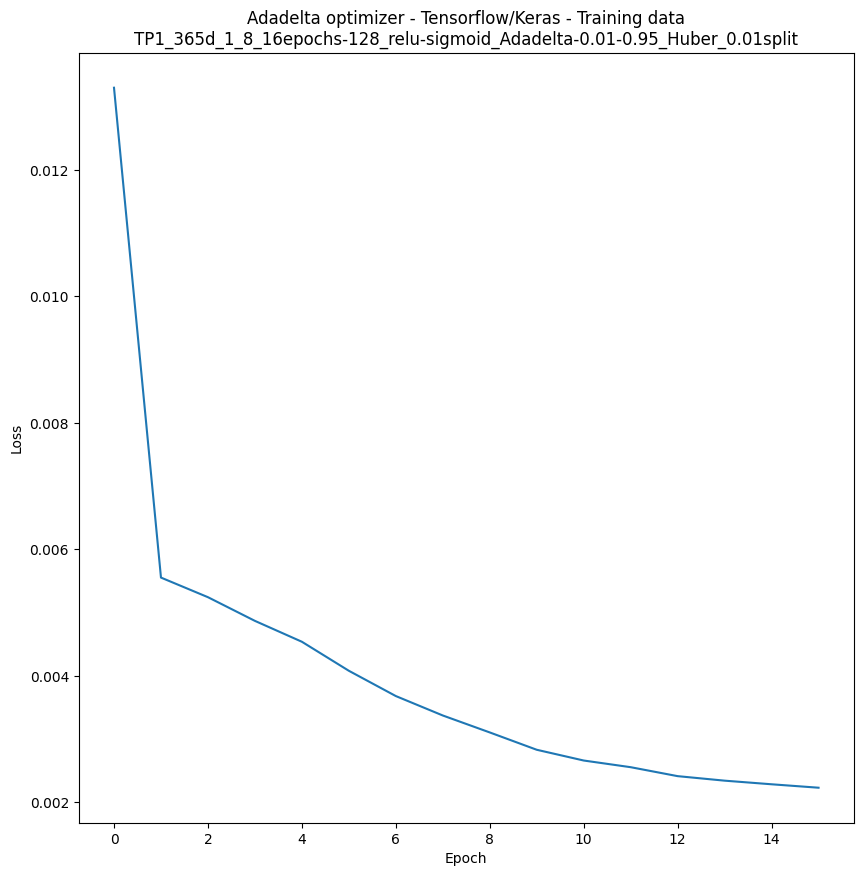

In [13]:
# Plot the loss history
print('Generating the history loss plot')

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)

plt.plot(history.epoch, history.history['loss'])

plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.title('Adadelta optimizer - Tensorflow/Keras - Training data\n' + expname)

plt.rcParams.update({'font.size': 18})

plt.axis(True)
plt.show()

loss_fig_file = os.path.join(path, '../outputs/' + expname + '_loss.png')
fig.savefig(loss_fig_file) 

In [14]:
# Model performance on the whole training data
train_loss = model.evaluate(input_train, output_train)
print("Training Mean Squared Error:", train_loss)

86/86 [==============================] - 0s 2ms/step - loss: 0.0027
Training Mean Squared Error: 0.002747545251622796


In [ ]:
# Model performance on testing data (unseen)
val_loss = model.evaluate(input_test, output_test)
print("Validation  Mean Squared Error:", val_loss)

22/22 [==============================] - 0s 2ms/step - loss: 0.0028
Validation  Mean Squared Error: 0.0027804262936115265


In [ ]:
# Save model
model_file = os.path.join(path, '../outputs/' + expname + '.h5')
model.save(model_file)

In [ ]:
# Load model
# from tensorflow import keras
# loaded_model = keras.models.load_model(model_file)

In [ ]:
# Model weights
weights = model.layers[0].get_weights()[0]

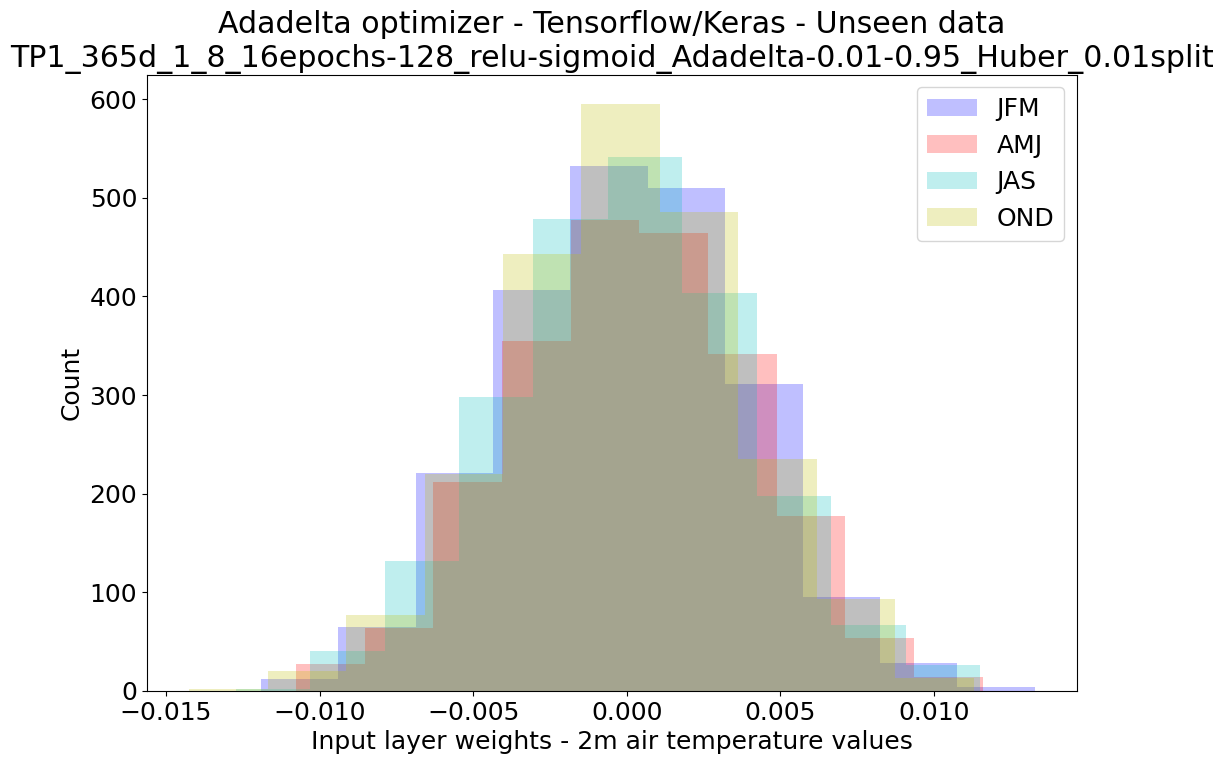

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

color = ['b', 'r', 'c', 'y']
for s in range(1, 5, 1):
    plt.hist(weights[1 + (s-1) * 91 * 24 : 1 + s * 91 * 24, :].mean(axis = 1).flatten(), alpha = 0.25, bins = 10, color = color[s-1])
plt.xlabel('Input layer weights - 2m air temperature values')
ax.set_ylabel('Count')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)
#plt.xlim(-0.015, 0.015)
ax.legend(['JFM', 'AMJ', 'JAS', 'OND'])
plt.axis(True)
plt.show()

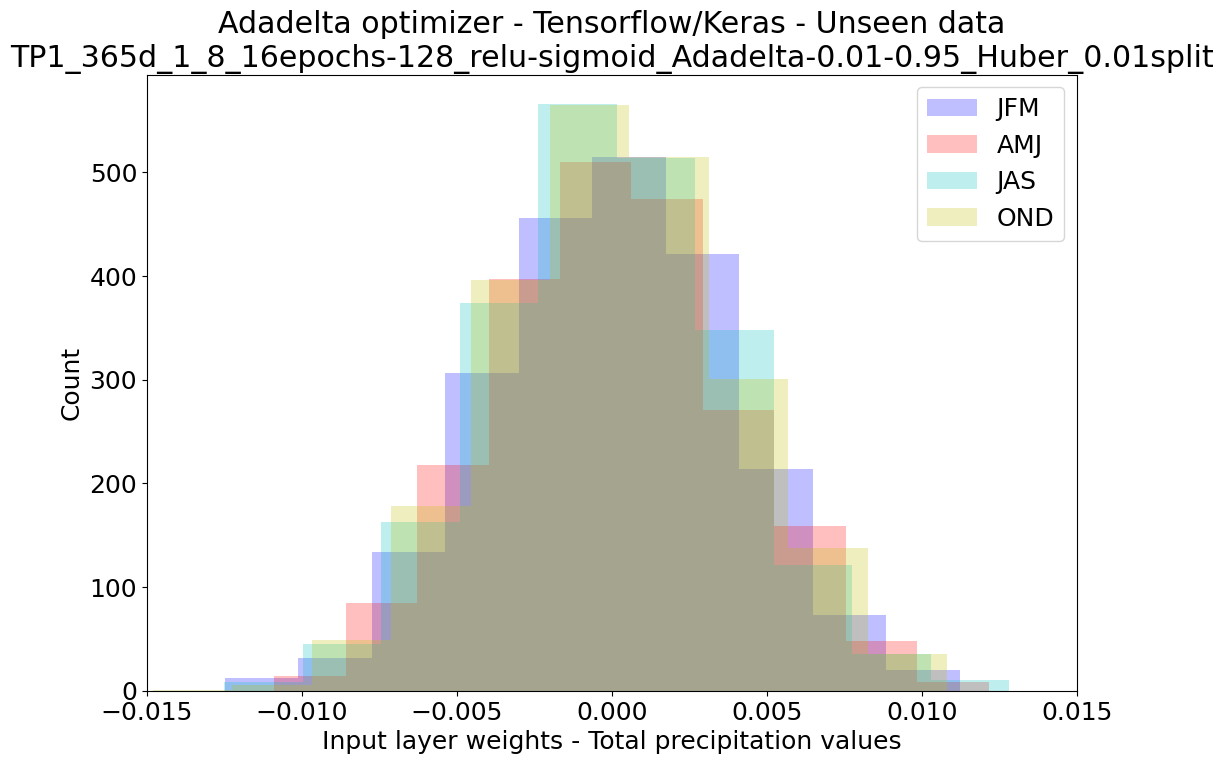

In [ ]:
fig = plt.figure(figsize = (12, 8))
ax = fig.add_subplot(111)

color = ['b', 'r', 'c', 'y']
for s in range(1, 5, 1):
    plt.hist(weights[8761 + (s-1) * 91 * 24 : 8761 + s * 91 * 24, :].mean(axis = 1).flatten(), alpha = 0.25, bins = 10, color = color[s-1])
plt.xlabel('Input layer weights - Total precipitation values')
ax.set_ylabel('Count')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)
plt.xlim(-0.015, 0.015)
ax.legend(['JFM', 'AMJ', 'JAS', 'OND'])
plt.axis(True)
plt.show()

In [ ]:
# Applying the model on the entire training dataset
output_train_forecast = model.predict(input_train)

86/86 [==============================] - 0s 2ms/step


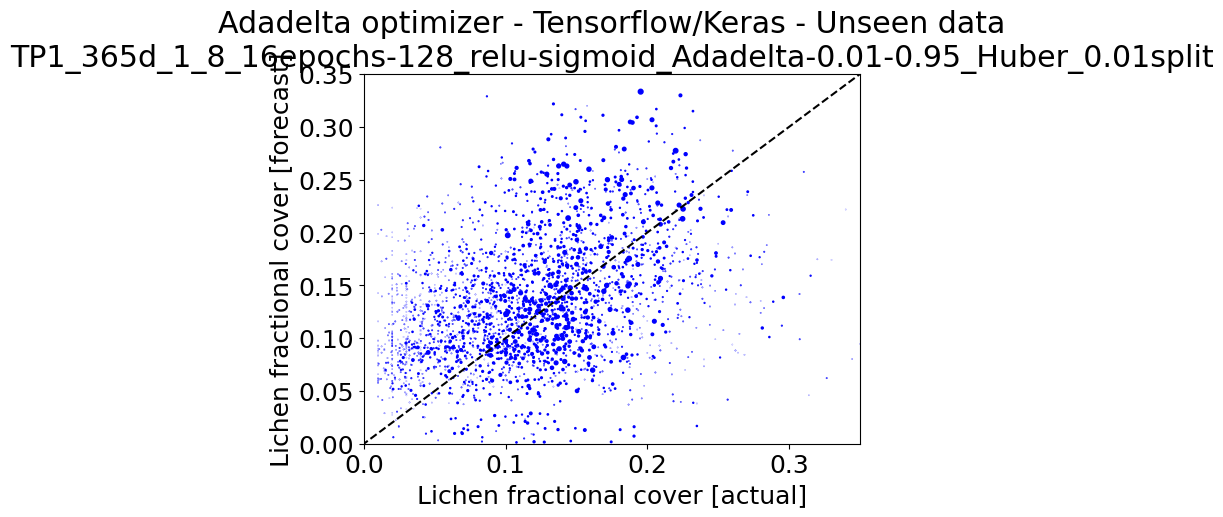

In [ ]:
# Forecast vs. actual Values xy-plot - Training data

fig = plt.figure()
ax = fig.add_subplot(111)

plt.scatter(output_train, output_train_forecast, c = 'blue', s = train_loss_weights / 250.)
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')

plt.ylabel('Lichen fractional cover [forecast]')
plt.xlabel('Lichen fractional cover [actual]')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.ylim(0., 0.35)
plt.xlim(0., 0.35)

plt.axis(True)
plt.show()

xy_fig_file = os.path.join(path, '../outputs/' + expname + '_xy.png')
fig.savefig(xy_fig_file) 

In [ ]:
# Perform a prediction
print('Forecasting', input_test.sum())
output_test_forecast = model.predict(input_test)

Forecasting Lichen       79.059727
t2m_0       663.352252
t2m_1       663.187766
t2m_2       663.105931
t2m_3       662.985537
              ...     
tp_8755    1215.865725
tp_8756    1277.371977
tp_8757    1335.443102
tp_8758    1389.414691
tp_8759    1441.569309
Length: 17521, dtype: float64
22/22 [==============================] - 0s 2ms/step


In [ ]:
output_test_forecast = pd.DataFrame(output_test_forecast.tolist())

In [ ]:
output_test_forecast.columns = ['Forecasted_lichen']

In [ ]:
output_test = output_test.reset_index().drop(columns=['index'])

In [ ]:
output_test.columns = ['Actual_lichen']

In [ ]:
# Calculate the cover
C_actual = (No_test.values * output_test['Actual_lichen'].values) * 100 * 100 / 1e06
C_forecast = (No_test.transpose().values * output_test_forecast['Forecasted_lichen'].values) * 100 * 100 / 1e06
TC_actual = C_actual.sum() 
TC_forecast = C_forecast.sum()
print('Total cover [in km2] = ', TC_forecast, ' (vs. ', TC_actual, ' actual)')
print('Total cover difference between actual and forecast [in %] = ', (((TC_actual - TC_forecast) / TC_actual * 100) * 100).astype('int') / 100)

Total cover [in km2] =  245.6865299641015  (vs.  219.22139986717502  actual)
Total cover difference between actual and forecast [in %] =  -12.07


In [ ]:
# Obtain m (slope) and b(intercept) of linear regression line
m, b = np.polyfit(output_test['Actual_lichen'], output_test_forecast['Forecasted_lichen'], 1, w = test_loss_weights)

In [ ]:
output_test

,Actual_lichen
0,0.079881
1,0.092609
2,0.043143
3,0.082727
4,0.212667
...,...
676,0.053333
677,0.030000
678,0.000000
679,0.106951


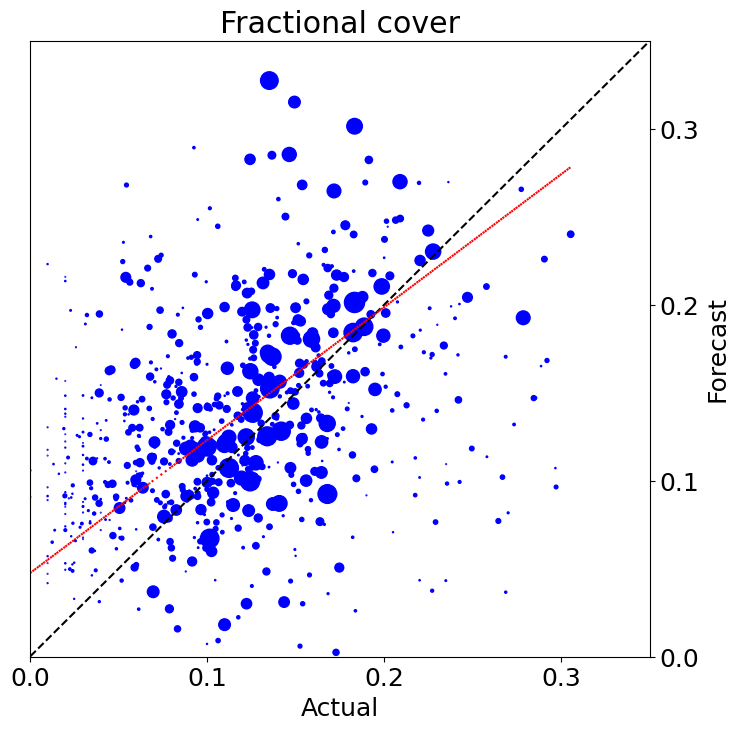

In [ ]:
# Forecast vs. actual Values xy-plot - Unseen data

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

plt.scatter(output_test, output_test_forecast, c = 'blue', s = test_loss_weights / 10.)
plt.plot([-5,20], [-5,20], color = 'black', ls = '--')
plt.plot(output_test['Actual_lichen'], m * output_test['Actual_lichen'] + b, color = 'red', ls = 'dotted')

plt.ylabel('Forecast')
ax.yaxis.set_label_position("right")
ax.yaxis.tick_right()
plt.xlabel('Actual')
plt.title('Fractional cover')
#plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.ylim(0., 0.35)
plt.xlim(0., 0.35)
plt.rcParams.update({'font.size': 32})

plt.axis(True)
plt.show()

xy_fig_file = os.path.join(path, '../outputs/' + expname + '_xy.png')
fig.savefig(xy_fig_file) 

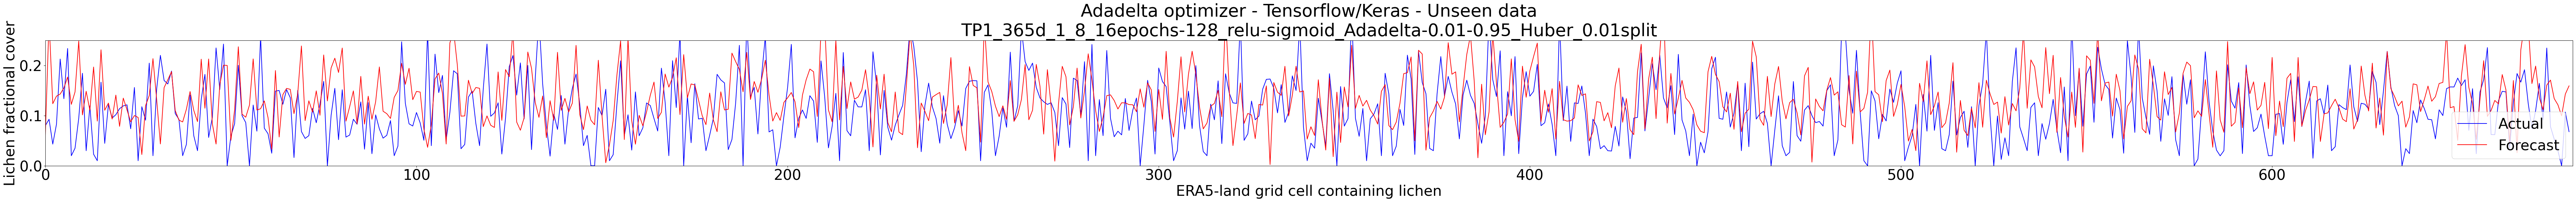

In [ ]:
# Forecast vs. actual Values linear-plot - Unseen data

fig = plt.figure(figsize=(100, 5))
ax = fig.add_subplot(111)

plt.plot(output_test, c = 'blue')
plt.plot(output_test_forecast, c = 'red')

plt.ylabel('Lichen fractional cover')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.xlim(0., len(output_test))
plt.ylim(0., 0.25)
ax.legend(['Actual', 'Forecast'])

LFC_fig_file = os.path.join(path, '../outputs/' + expname + '_LFC.png')
fig.savefig(LFC_fig_file) 

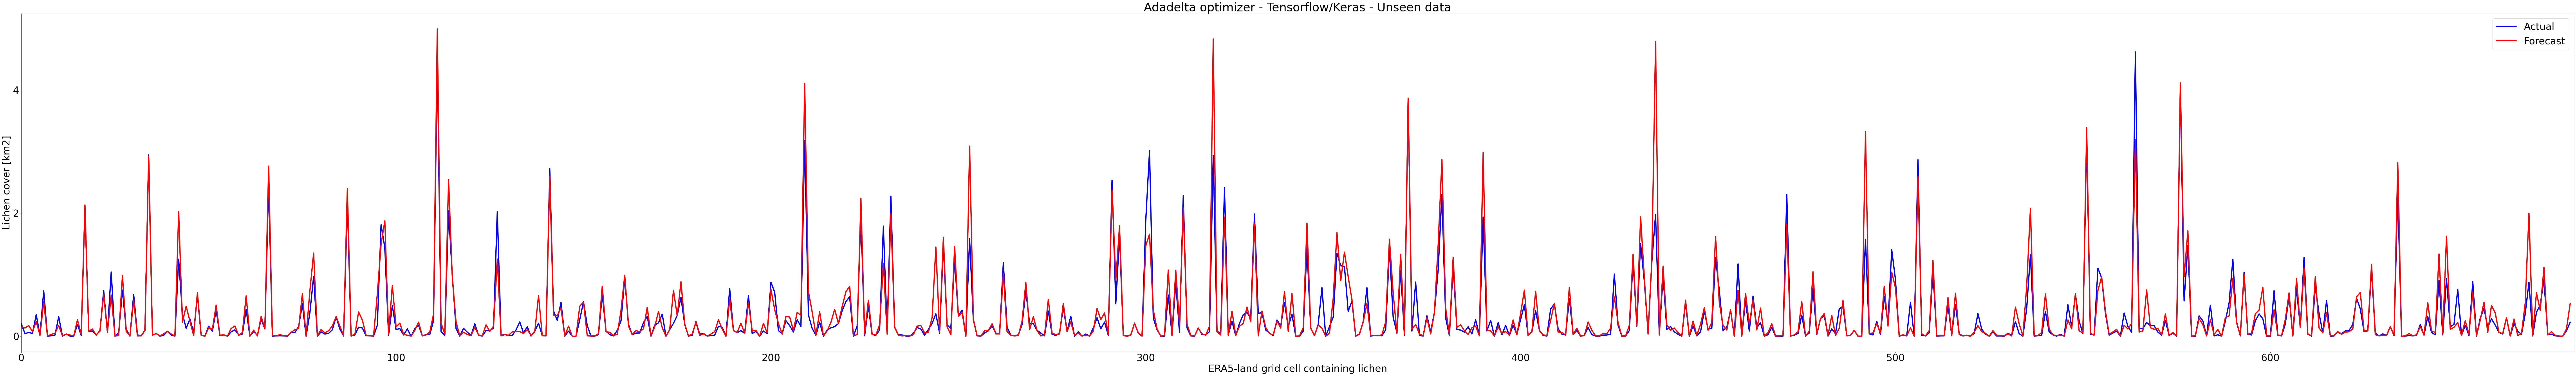

In [ ]:
# Forecast vs. actual cover linear-plot - Unseen data

fig = plt.figure(figsize=(150, 20), linewidth=2)
ax = fig.add_subplot(111)

plt.plot(C_actual, c = 'blue', linewidth=4)
plt.plot(C_forecast, c = 'red', linewidth=4)

plt.ylabel('Lichen cover [km2]')
plt.xlabel('ERA5-land grid cell containing lichen')
plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data')
#plt.title('Adadelta optimizer - Tensorflow/Keras - Unseen data\n' + expname)

plt.xlim(0., len(C_actual))
ax.legend(['Actual', 'Forecast'])
plt.rcParams.update({'font.size': 128})

LSC_fig_file = os.path.join(path, '../outputs/' + expname + '_LSC.png')
fig.savefig(LSC_fig_file, bbox_inches='tight') 

In [ ]:
print('Finished!')

Finished!
